### Hypothesis (James)
Certain medications are frequently prescribed together for COVID-19 treatment, forming distinct treatment patterns. These patterns could reveal standard treatment protocols that emerged during the pandemic and identify key medications that form the backbone of COVID-19 treatment regimens.

### Value
Understanding common medication pairings could help identify standard treatment protocols, as well as realize the complexity and variety of treatment approaches used. It can inform several key areas:
- Supply chain management: Helps hospitals optimize inventory of commonly co-prescribed medications
- Clinical guidance: Reveals real-world treatment patterns that could inform future treatment guidelines
- Resource allocation: Identifies critical medications that form common treatment combinations
- Quality of care: Enables comparison of treatment approaches across different healthcare facilities and regions

### Methodology
The analysis examines medication co-prescription patterns in COVID-19 patients through multiple steps:
1. Filtering confirmed COVID-19 cases from the dataset
2. Extracting all unique pairs of medications prescribed to each patient
3. Calculating the frequency of each medication pair
4. Creating network and distribution visualizations to reveal patterns
5. Analyzing the connectivity of individual medications to understand their role in treatment regimens


In [0]:
   #!pip install networkx

In [0]:
from pyspark.sql.functions import explode  
import networkx as nx  
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd  
import textwrap

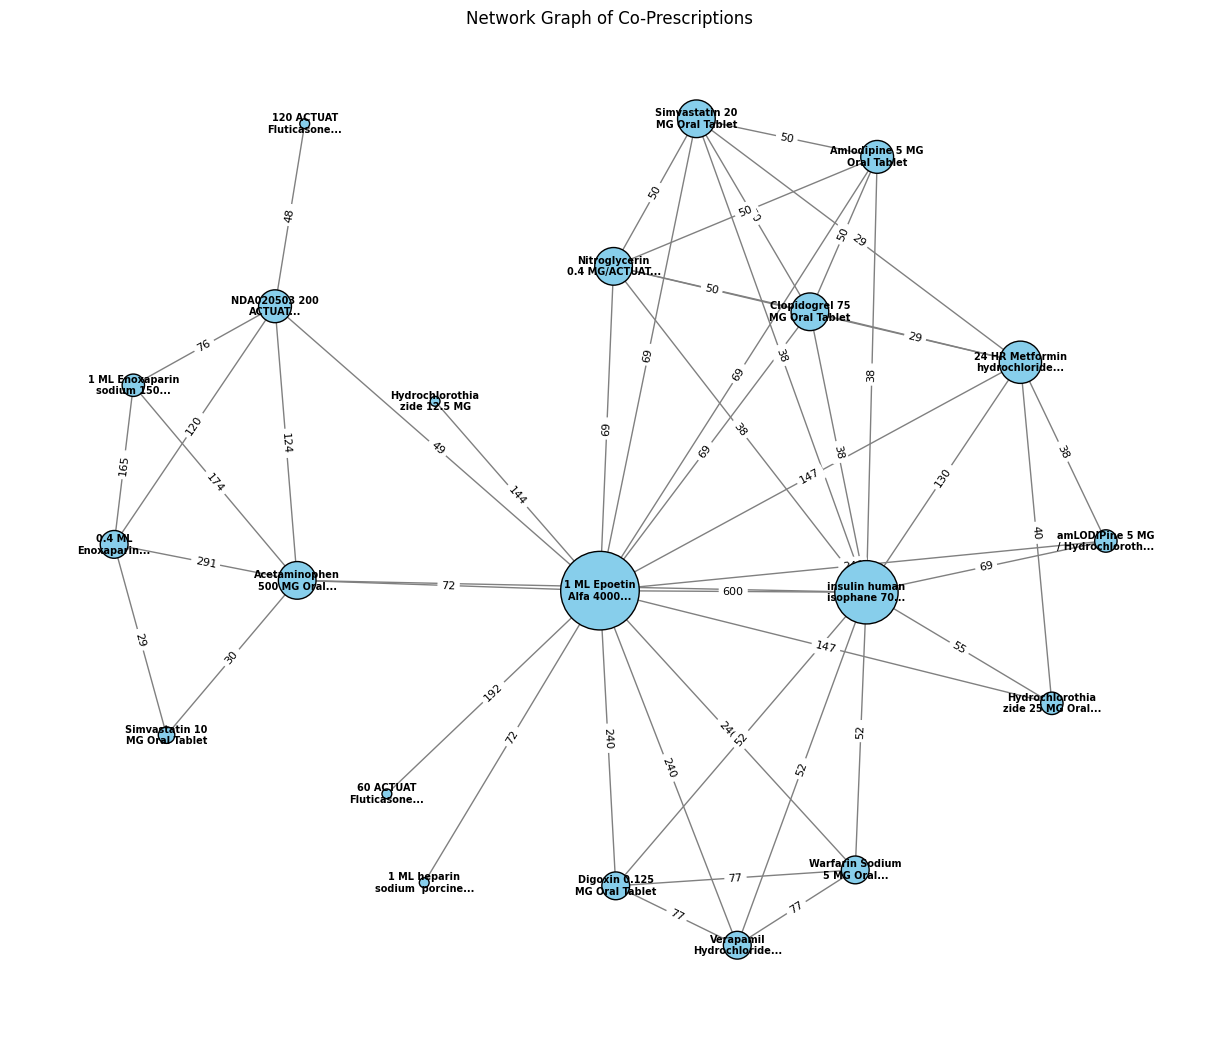

In [0]:
# Filter for confirmed COVID-19 cases  
covid_cases = parquet_df.filter("array_contains(conditions, 'COVID-19')")  

# Get medication pairs for COVID patients  
covid_medication_pairs = covid_cases \
    .select(explode("medications").alias("med1"), "medications") \
    .select("med1", explode("medications").alias("med2")) \
    .where("med1 < med2")  

# Count frequency of each pair in COVID cases, top 50  
covid_pair_counts = covid_medication_pairs \
    .groupBy("med1", "med2") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(50)  

# total_pairs_count = covid_medication_pairs.count()
# print(f"\nTotal number of medication pairs: {total_pairs_count}") 

# Collect data from Spark DataFrame to Python  
pairs = covid_pair_counts.collect()  

# Create a simple network graph  
G = nx.Graph()  

# Add edges to the graph  
for row in pairs:  
    G.add_edge(row['med1'], row['med2'], weight=row['count'])  

# Draw the graph with scaled node sizes
node_sizes = [50 * (G.degree(node) ** 1.5) for node in G.nodes]

# Use ForceAtlas2 layout algorithm to build network graph
pos = nx.forceatlas2_layout(G, strong_gravity=True, max_iter=1000)

# Function to handle long medication names
def format_label(label, max_length=15, max_lines=2):
    wrapped = textwrap.wrap(label, max_length)
    
    # Limit the number of lines and add ellipses if truncated
    if len(wrapped) > max_lines:
        wrapped = wrapped[:max_lines]
        wrapped[-1] += "..."  # Append ellipses to the last line
    
    # Join lines with newlines for multi-line formatting
    return "\n".join(wrapped)

formatted_labels = {node: format_label(str(node)) for node in G.nodes}

# Draw the graph with wrapped labels
plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos,
    labels=formatted_labels,  # Use the wrapped labels
    with_labels=True,
    node_size=node_sizes,
    node_color='skyblue',
    font_size=7,
    font_weight='bold',
    edge_color='gray',
    edgecolors='black'
)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Network Graph of Co-Prescriptions")
plt.show()

This is a network graph used to visualize (the top 50) relationships between medications that are prescribed together. Each node represents a different medication, with edges representing when two medications are prescribed together. Edge weights indicate the frequency in which those two medications are prescribed together in the dataset. The size of a node corresponds to the degree of the node, which is the number of connections (or edges) it has in the graph. In this context, the degree of a node is the number of unique medication pairs that include this medication.

From the graph, clustering reveals groups of medications commonly prescribed as a set. We can see that Epoetin Alfa injection acts as a central hub, being frequently prescribed with many other medications.

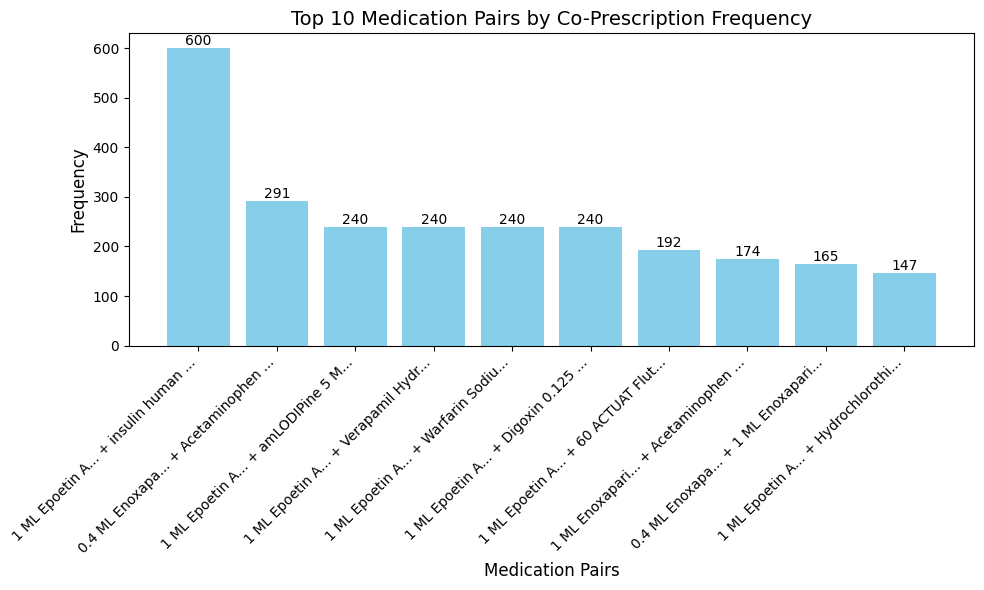

In [0]:
# Function to handle long medication names
def truncate_with_ellipsis(name, max_length=17):  
    if len(name) > max_length:  
        return name[:max_length-3] + '...'  # -3 for ellipsis  
    return name  

# Collect the top 10 pairs from the Spark DataFrame  
top_10_pairs = covid_pair_counts.limit(10)  

# Prepare the pairs with truncated names  
pairs = [" + ".join([truncate_with_ellipsis(row['med1']), truncate_with_ellipsis(row['med2'])]) for row in top_10_pairs.collect()]  
pair_counts = [row['count'] for row in top_10_pairs.collect()]

plt.figure(figsize=(10, 6))  
bars = plt.bar(pairs, pair_counts, color='skyblue')  

# Add the count on top of each bar  
for bar, count in zip(bars, pair_counts):  
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, count, ha='center', va='bottom', fontsize=10)  

plt.xlabel("Medication Pairs", fontsize=12)  
plt.ylabel("Frequency", fontsize=12)  
plt.title("Top 10 Medication Pairs by Co-Prescription Frequency", fontsize=14)  
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.tight_layout()  # Adjust layout for better spacing  
plt.show()  


This is a bar chart visualzing the most frequent medication pairs. Each bar represents a unique combination of two medications. The height of each bar shows how many times these medications were prescribed together. The data reveals that Epoetin Alfa and insulin human isophane is the most common pair with 600 co-prescriptions. This chart helps validate and quantify the patterns we see in the network graph. For example, the  edges in the network graph with bigger weights correspond to the tall bars in this chart.

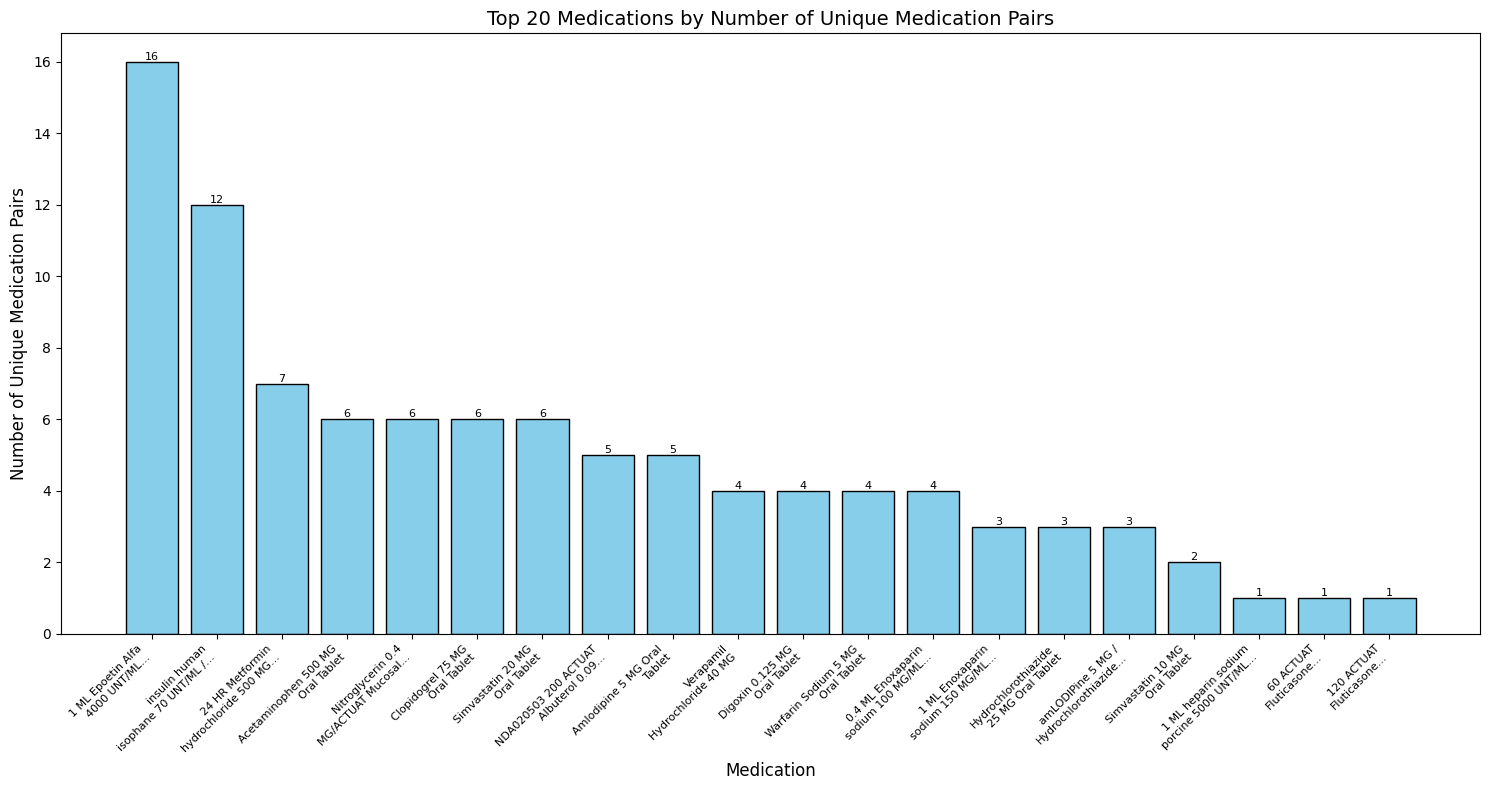

In [0]:
# Create a DataFrame of node degrees  
node_degrees = pd.DataFrame([  
    {'Medication': node, 'Degree': G.degree(node)}   
    for node in G.nodes()  
])  

# Sort in descending order to show most connected medications first  
node_degrees_sorted = node_degrees.sort_values('Degree', ascending=False).head(20)  

# Create the bar plot  
plt.figure(figsize=(15, 8))  
bars = plt.bar(  
    node_degrees_sorted['Medication'].apply(lambda x: format_label(x, max_length=20, max_lines=2)),   
    node_degrees_sorted['Degree'],   
    color='skyblue',   
    edgecolor='black'  
)  

plt.title('Top 20 Medications by Number of Unique Medication Pairs', fontsize=14)  
plt.xlabel('Medication', fontsize=12)  
plt.ylabel('Number of Unique Medication Pairs', fontsize=12)  
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.tight_layout()  

# Add value labels on top of each bar  
for bar in bars:  
    height = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2., height,  
             f'{height}',  
             ha='center', va='bottom', fontsize=8)  

plt.show()  

This is another bar chart that complements the network graph by quantifying the size of the nodes we see. This one displays which medications are prescribed with the most unique partners. The "Degree" on the y-axis represents how many different medications each drug is paired with. For instance, insulin human  isophane has the second highest degree of 12, meaning it's prescribed with 12 different medications. Medications with high degrees are the larger nodes in the network graph, and are thus the most "connected" medications. This helps identify the most versatile medications in COVID-19 treatment regimens.

Together, these visualizations tell a complete story: the network graph shows the overall structure of co-prescription patterns, the first bar chart quantifies the most common specific pairs, and the second bar chart reveals which individual medications are most commonly involved in these combinations. For example, we can see that while Epoetin Alfa forms many partnerships (high degree in chart 3), its combination with insulin human isophane is particularly common (highest bar in chart 2), and this is reflected by its prominent edge weight in the network graph.